
# How Bad Did It Shake?  Ordinal Modelling of Earthquake Damages
### Patricio Hernandez Senosiain
---


## Contents:

>[1 - Introduction](#1---Introduction)
>
>[2 - Imports](#2---Imports)
>
>[3 - Data retrieval and exploratory analysis](#3---Data-retrieval-and-exploratory-analysis)
>
>[4 - Data cleaning and preprocessing](#4---Data-cleaning-and-preprocessing)
>
>[5 - Modelling](#5---Modelling)
>
>[6 - Conclusion](#6---Conclusion)
>


## 1 - Introduction

## 2 - Imports and utilities

### 2.1 - Imports

In [39]:
# Scikit learn - preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer

# Scikit learn - model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score, cross_validate

# Scikit learn - model evaluation
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report

# Scikit learn - modelling
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsOneClassifier, OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

# CatBoost - modelling
from catboost import CatBoostClassifier

# Category Encoders - feature encoding
from category_encoders import TargetEncoder, LeaveOneOutEncoder, CatBoostEncoder 

# Pandas and Numpy - data handling
import pandas as pd
import numpy as np

# Imbalanced-learn - imbalanced classification
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# Matplotlib and Seaborn - visualizations
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 - Utilities

In [ ]:
# Setting up utilities

# Declaring standard Seaborn color palette
standard_palette = []
for i in range(10):
    standard_palette += list(sns.color_palette('muted'))


# Convergence warning disabling
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
#simplefilter("ignore", category=ConvergenceWarning)

# Setting a random seed
SEED = 105

## 3 - Data retrieval and exploratory analysis

### 3.1 - Data retrieval

In [2]:
train_features = pd.read_csv('data/train_values.csv')
train_target = pd.read_csv('data/train_labels.csv')

### 3.2 - General overview

In [3]:
print('Features data:')
train_features.info(verbose=False)
print('')
print('Target data:')
train_target.info(verbose=False)

Features data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Columns: 39 entries, building_id to has_secondary_use_other
dtypes: int64(31), object(8)
memory usage: 77.5+ MB

Target data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Columns: 2 entries, building_id to damage_grade
dtypes: int64(2)
memory usage: 4.0 MB


In [4]:
train_features.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,...,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,...,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,...,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,...,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_target.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


In [6]:
data = train_features.merge(train_target, on='building_id' )
data = data.drop(columns='building_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 


#### **NOTES FROM (3.2):**

* (Notes)

It is necessary to further classify features based on their statistical data types. With the aid of the [data description section](https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/), we classified the features as follows:


#### **FEATURE CLASSIFICATION:**
|**Categorical**                            |**Count**               |**Continuous**      |
|-------------------------------------------|------------------------| -------------------|
|`land_surface_condition`                   |`count_floors_pre_eq`   |`geo_level_1_id`    |
|`foundation_type`                          |`age`                   |`geo_level_2_id`    |
|`roof_type`                                |`count_families`        |`geo_level_3_id`    |
|`ground_floor_type`                        |                        |`area_percentage`   |
|`other_floor_type`                         |                        |`height_percentage` |
|`position`                                 |                        |                    | 
|`plan_configuration`                       |                        |                    |
|`has_superstructure_adobe_mud`             |                        |                    |
|`has_superstructure_mud_mortar_stone`      |                        |                    |
|`has_superstructure_stone_flag`            |                        |                    |
|`has_superstructure_cement_mortar_stone`   |                        |                    |
|`has_superstructure_mud_mortar_brick`      |                        |                    |
|`has_superstructure_cement_mortar_brick`   |                        |                    |
|`has_superstructure_timber`                |                        |                    |
|`has_superstructure_bamboo`                |                        |                    |
|`has_superstructure_rc_non_engineered`     |                        |                    |
|`has_superstructure_rc_engineered`         |                        |                    |
|`has_superstructure_other`                 |                        |                    |
|`legal_ownership_status`                   |                        |                    |
|`has_secondary_use`                        |                        |                    |
|`has_secondary_use_agriculture`            |                        |                    |
|`has_secondary_use_hotel`                  |                        |                    |
|`has_secondary_use_rental`                 |                        |                    |
|`has_secondary_use_institution`            |                        |                    |
| `has_secondary_use_school`                |                        |                    |
|`has_secondary_use_industry`               |                        |                    |
|`has_secondary_use_health_post`            |                        |                    |
|`has_secondary_use_gov_office`             |                        |                    |
|`has_secondary_use_use_police`             |                        |                    |
|`has_secondary_use_other`                  |                        |                    |



In [7]:
cont_feats = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'area_percentage', 'height_percentage']
count_feats = ['count_floors_pre_eq', 'age', 'count_families']
cat_feats = data.drop(columns=cont_feats+count_feats).columns.tolist()
cat_feats.remove('damage_grade')

### 3.3 - Distribution of target variable

In [8]:
# Summary statistics for target variable
data['damage_grade'].describe()

count    260601.000000
mean          2.238272
std           0.611814
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: damage_grade, dtype: float64

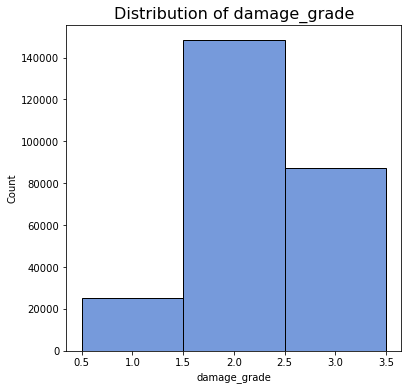

In [9]:
# Plotting distribution of values for target variable
f, axs = plt.subplots(figsize=(6, 6))
sns.histplot(data, x='damage_grade', color=standard_palette[0], fill=True, discrete=True, ax=axs)
plt.title('Distribution of damage_grade', size=16)
plt.show()


#### **NOTES FROM (3.3):**

* (Notes)

### 3.4 - Distribution of continuous features

In [10]:
data[cont_feats].describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,area_percentage,height_percentage
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,8.018051,5.434365
std,8.033617,412.710734,3646.369645,4.392231,1.918418
min,0.000000,0.000000,0.000000,1.000000,2.000000
25%,7.000000,350.000000,3073.000000,5.000000,4.000000
50%,12.000000,702.000000,6270.000000,7.000000,5.000000
75%,21.000000,1050.000000,9412.000000,9.000000,6.000000
max,30.000000,1427.000000,12567.000000,100.000000,32.000000


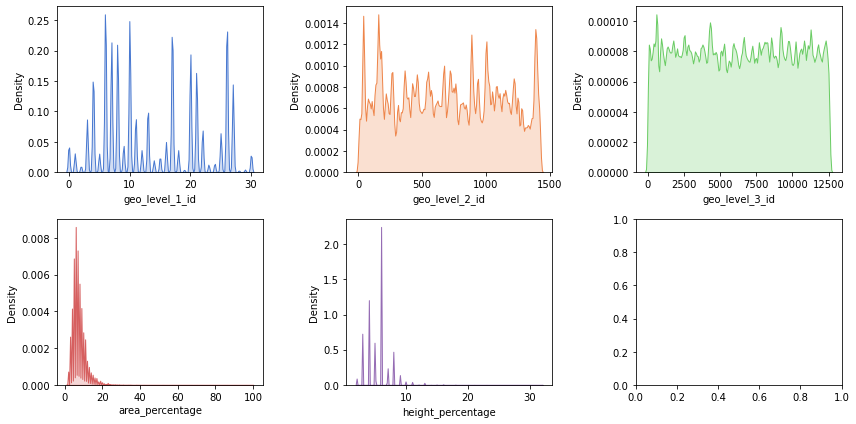

In [11]:
# Plotting distribution of data for continuous features
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(12, 6)
for i in range(len(cont_feats)):
    sns.kdeplot(data[cont_feats].iloc[:, i].dropna(), 
                ax=axs[i//3, i % 3],
                color=standard_palette[i], 
                fill=True, 
                bw_adjust=0.2)

plt.tight_layout()


#### **NOTES FROM (3.4):**

* Log-transform is required for `area_percentage` to reduce skewness.

### 3.5 - Distribution of count features

In [12]:
data[count_feats].describe()

,count_floors_pre_eq,age,count_families
count,260601.000000,260601.000000,260601.000000
mean,2.129723,26.535029,0.983949
std,0.727665,73.565937,0.418389
min,1.000000,0.000000,0.000000
25%,2.000000,10.000000,1.000000
50%,2.000000,15.000000,1.000000
75%,2.000000,30.000000,1.000000
max,9.000000,995.000000,9.000000


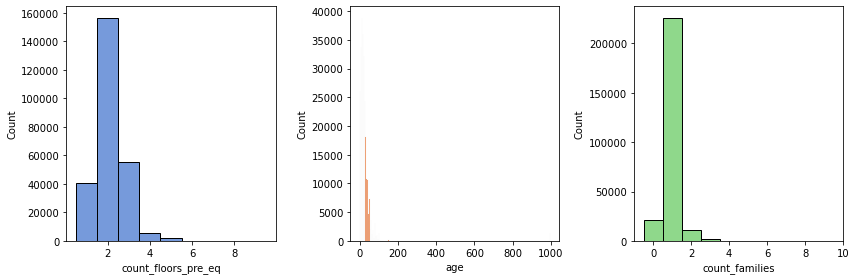

In [13]:
# Plotting distribution of data for discrete features
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
for i in range(len(count_feats)):
    sns.histplot(x=data[count_feats].iloc[:, i].dropna(),
                 ax=axs[i % 3],
                 color=standard_palette[i],
                 discrete=True)

plt.tight_layout()

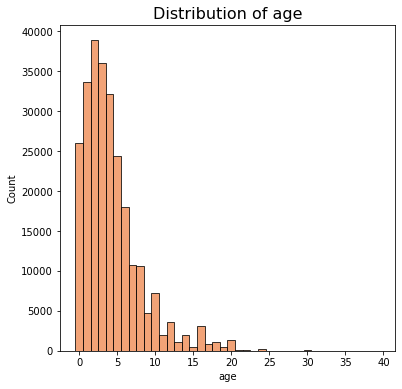

In [14]:
f, axs = plt.subplots(figsize=(6, 6))
trans_age = data[data['age'] < 200]
trans_age = trans_age['age']/5
sns.histplot(x=trans_age, 
             ax=axs, 
             color=standard_palette[1], 
             discrete=True)
plt.title('Distribution of age', size=16)
plt.show()


#### **NOTES FROM (3.3):**

* Significant outliers for `age`. Removal is required.
* Log-transform and scaling by 5 required for `age`.

### 3.6 - Distribution of categorical features

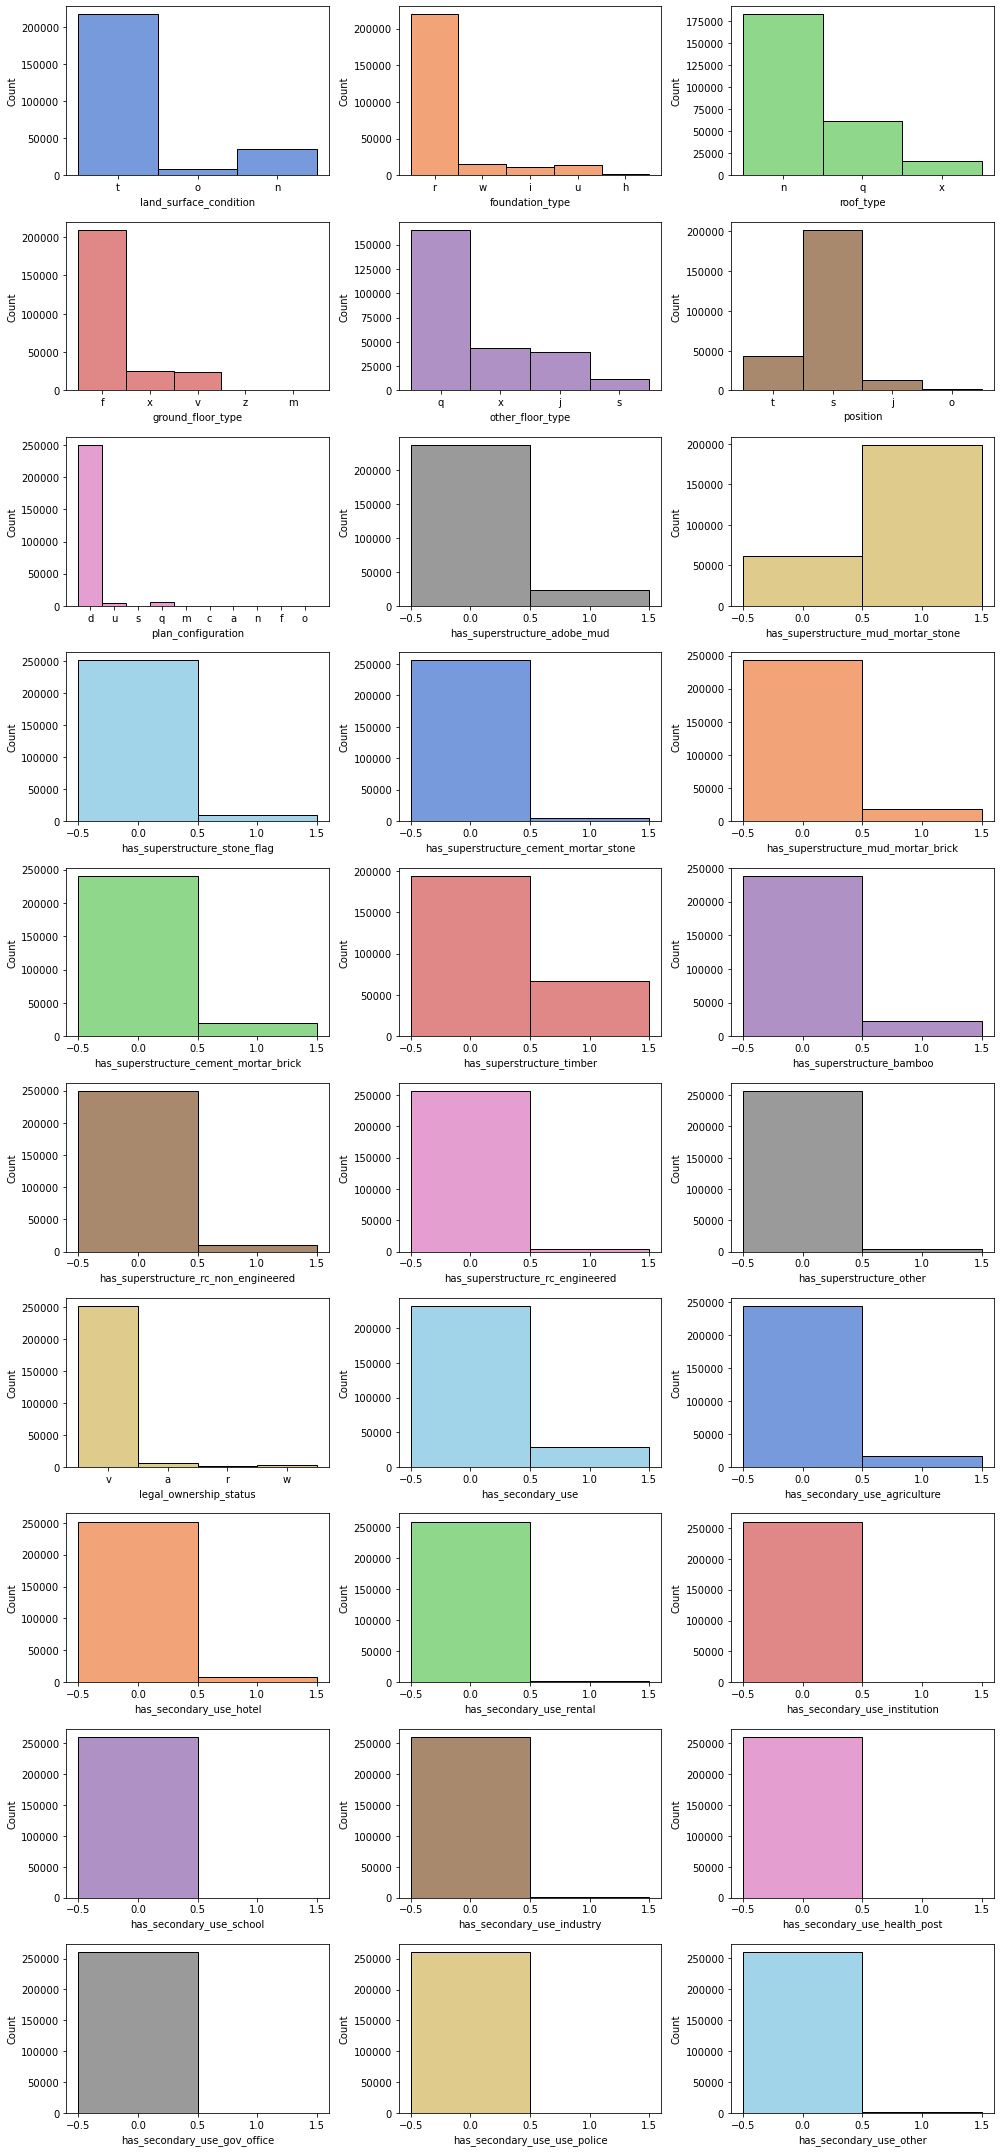

In [15]:
# Plotting distribution of data for categorical features
fig, axs = plt.subplots(10, 3)
fig.set_size_inches(14, 30)
for i in range(len(cat_feats)):
    p = sns.histplot(x=data[cat_feats].iloc[:, i].dropna(),
                     ax=axs[i//3, i % 3], 
                     discrete=True,
                     color=standard_palette[i])
    
plt.tight_layout()


#### **NOTES FROM (3.3):**
* Dummy encoding required for the following variables: `land_surface_condition`, `foundation_type`, `roof_type`, `ground_floor_type`, `other_floor_type`, `position`, `plan_configuration`.
* Check class imbalance for binary variables. Consider grouping

### 3.7 - Bivariate analysis of continuous features

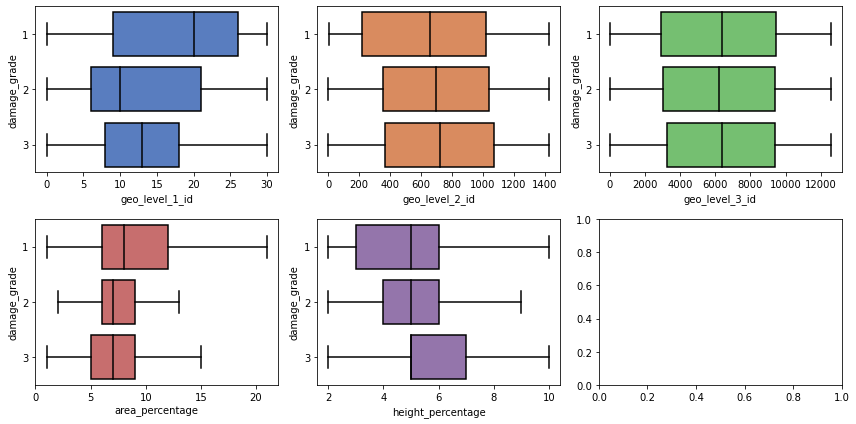

In [16]:
# Plotting scaterrplots of continuous features versus target variable

props ={'boxprops': {'edgecolor': 'black'}, 
        'medianprops': {'color': 'black'}, 
        'whiskerprops': {'color': 'black'}, 
        'flierprops': {'color': 'black'}, 
        'showfliers': False, 
        'capprops': {'color': 'black'}
       }

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(12, 6)
for i in range(len((cont_feats))):
    sns.boxplot(x=data[cont_feats].iloc[:, i], 
                y=data['damage_grade'],
                ax=axs[i//3, i % 3],
                orient='h',
                color=standard_palette[i], 
                **props)

plt.tight_layout()

### 3.8 - Bivariate analysis of count features

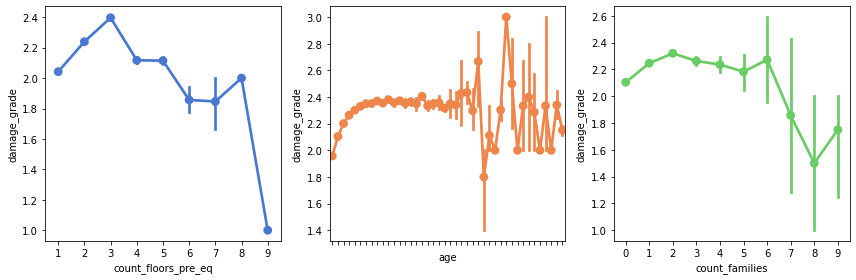

In [17]:
# Plotting mean ln(1+SalePrice) for discrete features
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
for i in range(len(count_feats)):
    p = sns.pointplot(x=data[count_feats].iloc[:, i].dropna(), 
                      y=data['damage_grade'],
                      ax=axs[i % 3],
                      color=standard_palette[i])
    if i in [1]:
        p.set(xticklabels=[])
plt.tight_layout()    

### 3.9 - Bivariate analysis of categorical features

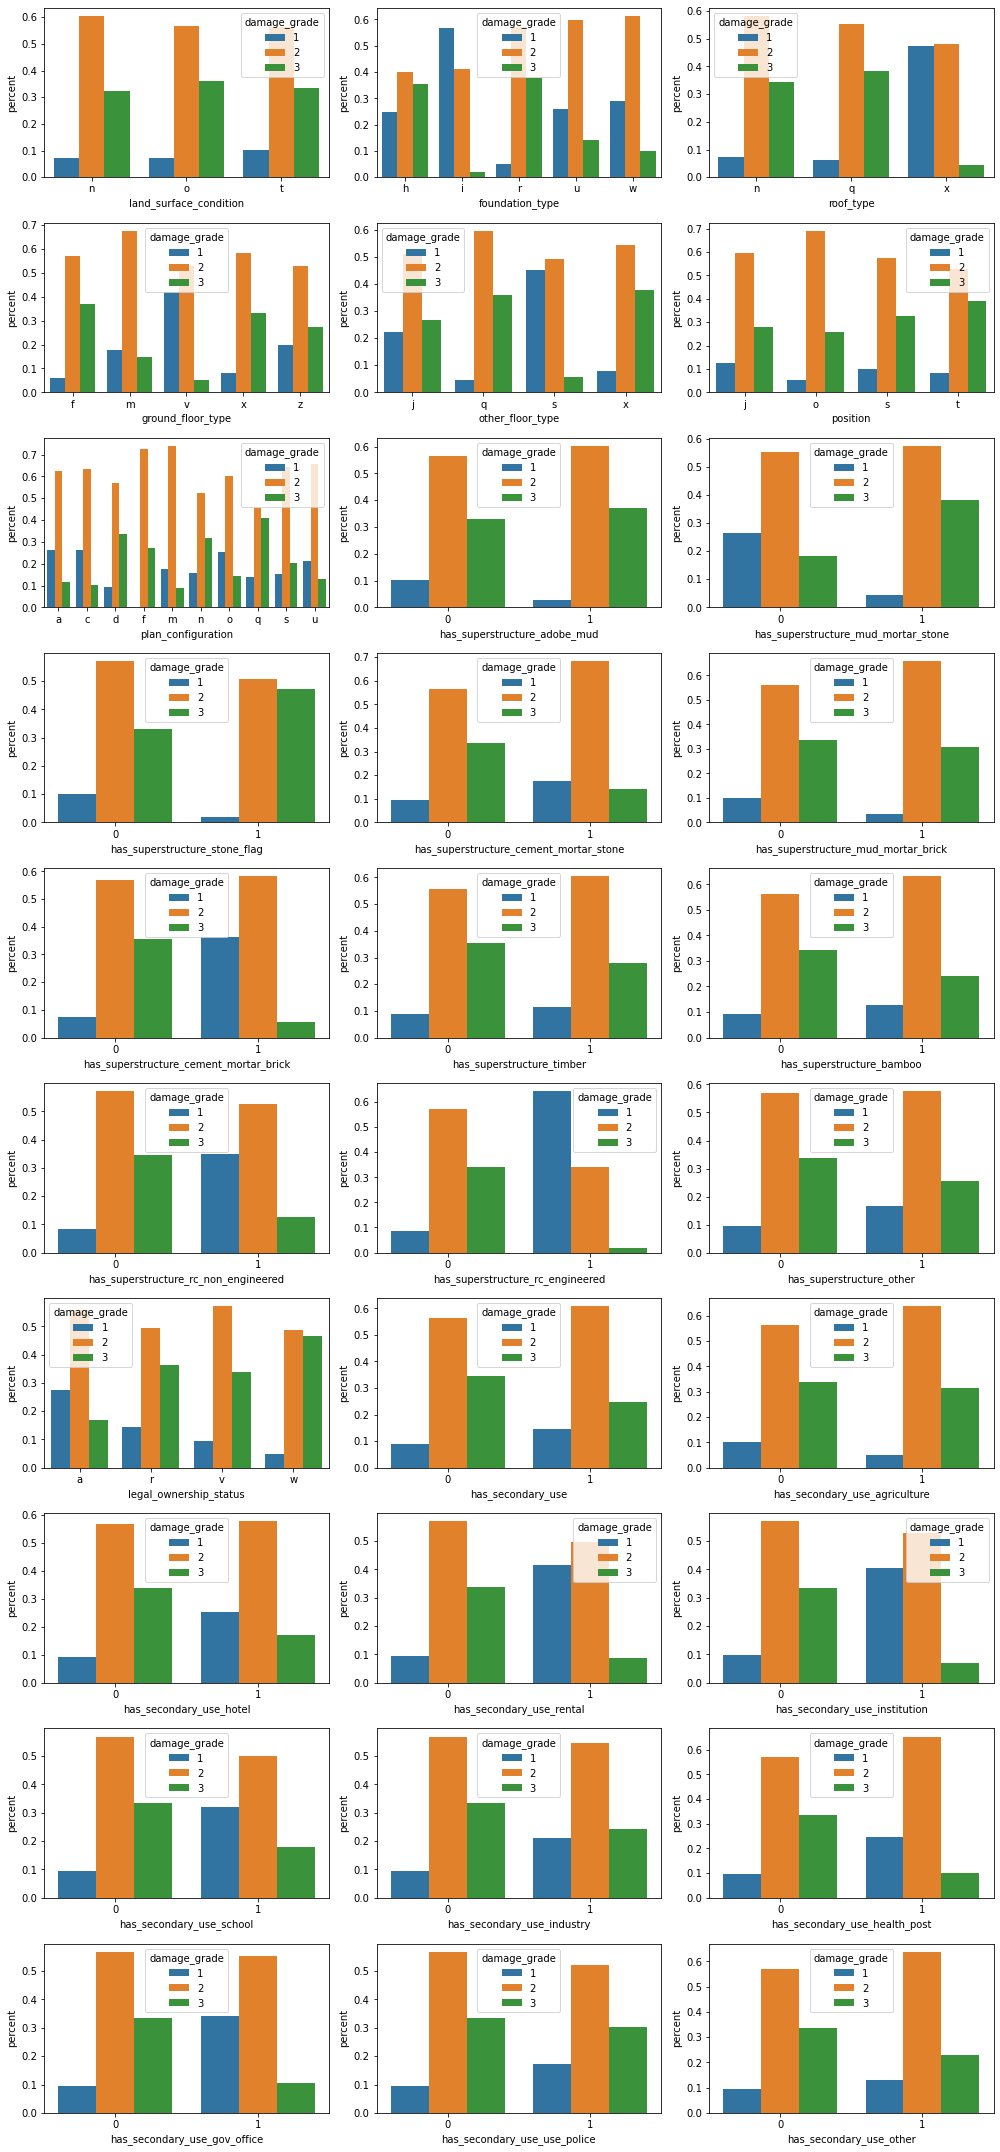

In [18]:
fig, axs = plt.subplots(10, 3)
fig.set_size_inches(14, 30)
for i in range(len(cat_feats)):
    pct = (data.groupby([cat_feats[i],'damage_grade']).size() / data.groupby([cat_feats[i]]).size()).reset_index().rename({0:'percent'}, axis=1)
    sns.barplot(x=cat_feats[i],
                y='percent',
                hue='damage_grade',
                data=pct,
                ax=axs[i//3, i % 3])

plt.tight_layout()

### 3.10 - Correlation between features

## 4 - Data cleaning

### 4.1 - Outliers

In [19]:
data = data[data['age'] < 100]

### 4.2 - Retrieving and merging test data

In [20]:
# Retrieving test data and printing general overview
test_data = pd.read_csv('data/test_values.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   building_id                             86868 non-null  int64 
 1   geo_level_1_id                          86868 non-null  int64 
 2   geo_level_2_id                          86868 non-null  int64 
 3   geo_level_3_id                          86868 non-null  int64 
 4   count_floors_pre_eq                     86868 non-null  int64 
 5   age                                     86868 non-null  int64 
 6   area_percentage                         86868 non-null  int64 
 7   height_percentage                       86868 non-null  int64 
 8   land_surface_condition                  86868 non-null  object
 9   foundation_type                         86868 non-null  object
 10  roof_type                               86868 non-null  object
 11  gr

In [21]:
# Separating 'Id' column
ID = test_data['building_id']
test_data = test_data.drop(columns='building_id')

# Joining test and training datasets
data = data.append(test_data, sort=False)

# Printing dataset summary
print('')
print('Merged dataset')
data.info(verbose=False)
print('')



Merged dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 343981 entries, 0 to 86867
Columns: 39 entries, geo_level_1_id to damage_grade
dtypes: float64(1), int64(30), object(8)
memory usage: 105.0+ MB



In [22]:
data.head(10)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2.0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
3,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2.0
4,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3.0
5,8,558,6089,2,10,9,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2.0
6,9,475,12066,2,25,3,4,n,r,n,...,0,0,0,0,0,0,0,0,0,3.0
7,20,323,12236,2,0,8,6,t,w,q,...,0,0,0,0,0,0,0,0,0,1.0
8,0,757,7219,2,15,8,6,t,r,q,...,0,0,0,0,0,0,0,0,0,2.0
9,26,886,994,1,0,13,4,t,i,n,...,0,0,0,0,0,0,0,0,0,1.0


### 4.3 - Highly correlated features

### 4.8 - Feature transforms

In [23]:
data['area_percentage'] = np.log1p(data['area_percentage']) 

data['age'] = data['age']/5

## 5 - Modelling

### 5.1 - Evaluation metrics


Although this is an ordinal regression problem, the metric used by Driven Data to evaluate models for this competition is the micro averaged F1 score across the three classes:

$$ F_{micro} \; = \; \frac{2 \cdot P_{micro} \cdot R_{micro} }{P_{micro} + R_{micro} }$$

where $P_{micro}$ and $R_{micro}$ stand for the precision and recall metrics :


$$ P_{micro} \;=\; \frac{\sum^3_{k=1} TP_k}{\sum^3_{k=1}TP_k + FP_k} \;,\; R_{micro} \;=\; \frac{\sum^3_{k=1}TP_k}{\sum^3_{k=1}TP_k + TN_k} $$

In [24]:
def model_score(y_true, y_pred):
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print('')
    print('Micro F1 Score)
    print(f1_score(y_true, y_pred, average='micro'))
    
    return f1_score(y_true, y_pred, average='micro')

### 5.2 - Defining feature matrices and target vectors

In [25]:
# Separating training and test matrices
train = data[data['damage_grade'].isnull()==False]
test = data[data['damage_grade'].isnull()]

# Creating feature matrix and target vector from training sample
X_train = train.drop(columns='damage_grade')
y_train = train['damage_grade']

# Creating feature matrix from test sample
X_test = test.drop(columns='damage_grade')


### 5.3 - Logistic regression modelling

In [26]:
# Creating logistic regression preprocessing pipeline
log_reg_preprocessing_pipe = ColumnTransformer(
    [
        ('continuous', RobustScaler(), cont_feats), 
        ('categorical', OneHotEncoder(drop='first'), cat_feats)
    ], 
    remainder='passthrough'
)    

In [27]:
## Creating Logistic Regression pipeline --- hyperparameter has been optimized
log_reg_pipeline = Pipeline([('preprocessing', log_reg_preprocessing_pipe), 
                             ('model', OneVsOneClassifier(LogisticRegression(max_iter=1600, 
                                                                             random_state=SEED)))])
#
## Running initial 10 - fold cross validation
#print('Running Logistic Regression ...')
#%time cv = cross_val_score(log_reg_pipeline, X_train, y_train,scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.4 - SVM modelling

In [28]:
# Creating SVM preprocessing pipeline
svm_preprocessing_pipe = ColumnTransformer(
    [
        ('continuous', RobustScaler(), cont_feats), 
        ('categorical', OneHotEncoder(drop='first') , cat_feats)
    ], 
    remainder='passthrough'
)

svm_params = {'model__estimator__C': np.logspace(-1,1,20) }

In [29]:
## Creating SVM pipeline --- hyperparameter has been optimized
svm_pipeline = Pipeline([('preprocessing', svm_preprocessing_pipe), 
                         ('model', OneVsOneClassifier(LinearSVC(random_state=SEED,
                                                                C=6.5,
                                                                dual=False)))])
#
## Running initial 10 - fold cross validation
#print('Running SVM ...')
#%time cv = cross_val_score(svm_pipeline, X_train, y_train,scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)
#

### 5.5 - Random forest modelling

In [30]:
# Creating Random Forest preprocessing pipeline
rf_preprocessing_pipe = ColumnTransformer( [ ('categorical', CatBoostEncoder(random_state=SEED) , cat_feats) ], remainder='passthrough'))

# Hyperparameters for Random Forest regressor
rf_params = {'model__n_estimators': np.arange(200, 350, 10),
             'model__max_depth': np.arange(20, 60, 2),
             'model__min_samples_split': np.arange(36, 160, 2),
             'model__min_samples_leaf': np.arange(1, 14, 1) 
             }

In [31]:
## Creating Random Forest pipeline --- hyperparameter has been optimized
rf_pipeline = Pipeline([('preprocessing', rf_preprocessing_pipe), 
                        ('model', RandomForestClassifier(n_estimators=350, 
                                                         max_depth=40, 
                                                         min_samples_split=46, 
                                                         min_samples_leaf=8, 
                                                         random_state=SEED))])
 
## Running initial 10 - fold cross validation 
#print('Running Random Forest ...')
#%time cv = cross_val_score(rf_pipeline, X_train, y_train,scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)
#

### 5.6 - AdaBoost modelling

In [32]:
# Creating Gradient Boosting preprocessing pipeline
adaboost_preprocessing_pipe = ColumnTransformer(
    [
        ('continuous', RobustScaler(), cont_feats),
        ('categorical', CatBoostEncoder(random_state=SEED) , cat_feats)
    ], 
    remainder='passthrough'
)

adaboost_params = {'model__n_estimators': np.arange(280, 350, 10),
                   'model__base_estimator__max_depth': np.arange(2, 8, 1)
                  }

In [33]:
# Creating Random Forest pipeline --- hyperparameter has been optimized (model__n_estimators = 310)
adaboost_pipeline = Pipeline([('preprocessing', adaboost_preprocessing_pipe), 
                              ('model', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                           n_estimators = 310,
                                                           random_state=SEED))])

## Running initial 10 - fold cross validation 
#print('Running AdaBoost ...')
#%time cv = cross_val_score(adaboost_pipeline, X_train, y_train, scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv) 

Running AdaBoost ...
Finished running


### 5.7 - Catboost modelling

In [35]:
catboost_pipeline = Pipeline([ ('model', CatBoostClassifier(cat_features=cat_feats, 
                                                            loss_function='MultiClass'))])
## Running initial 10 - fold cross validation 
#print('Running CatBoost ...')
#%time cv = cross_val_score(catboost_pipeline, X_train, y_train, scoring=make_scorer(model_score),cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

Running CatBoost ...
Finished running


### 5.8 - Estimator stacking

In [36]:
# Preparing best estimators to pass into stacked model
final_estimators = [('CatBoost', catboost_pipeline), 
                    ('AdaBoost', adaboost_pipeline), 
                    ('Random Forest', rf_pipeline), 
                    ('SVM', svm_pipeline), 
                    ('Logistic Regression', log_reg_pipeline)]

#stack = StackingClassifier(estimators=final_estimators, cv=5)
#
#print('Running stacked estimator model...')
#%time cv = cross_val_score(stack, X_train, y_train, scoring=make_scorer(model_score), cv=5, n_jobs=-1)
#print('Finished running')
#print('Score: ', cv)

### 5.9 - Final model

In [ ]:
# Create estimator with optimal hyperparameters
final_model = StackingClassifier(final_estimator = OneVsOneClassifier(LogisticRegression(max_iter=1600, 
                                                                                         random_state=SEED)), 
                                 estimators=final_estimators, 
                                 n_jobs=-1)

# Fit model with complete training sample
final_model.fit(X_train, y_train)


## 6 - Final predictions and submission

In [38]:
# Creating submission file
preds = final_model.predict(X_test)
output = pd.DataFrame({'building_id': ID, 'damage_grade': preds})
output = output.astype(int)
output.to_csv('submission.csv', index=False)